## ML Modeling

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from skopt import BayesSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score

from helper import *

import xgboost as xgb
import lightgbm as lgb

import joblib

SEED = 42

In [2]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
dias = pd.read_excel("DIAS Attributes - Values 2017.xlsx", header=1)
dias['Attribute'] = dias['Attribute'].ffill()

In [4]:
target = mailout_train['RESPONSE']
mailout_train.drop(['RESPONSE'], inplace=True, axis=1)
mailout_train.drop(['LNR'], inplace=True, axis=1)

In [5]:
mailout_train_eng = preprocess(mailout_train, dias)

Dropping columns with high percentage of missing values ['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ']
label encoding CAMEO_DEU_2015
Convert CAMEO_DEUG_2015 str to float
Mapping OST_WEST_KZ categorical
Splitting CAMEO_INTL_2015 Feature into 2 features FAMILY and WEALTH
Splitting LP_LEBENSPHASE_FEIN into two features INCOME and AGE
Splitting PRAEGENDE_JUGENDJAHRE into two DECADE and MOVEMENT
Get the registeration year from EINGEFUEGT_AM
Dropping unwanted columns ['D19_LETZTER_KAUF_BRANCHE', 'CAMEO_INTL_2015', 'LP_LEBENSPHASE_FEIN', 'PRAEGENDE_JUGENDJAHRE', 'EINGEFUEGT_AM']
Imputing missing values with most frequent value


In [6]:
mailout_train_eng.columns.values

array(['AKT_DAT_KL', 'ALTERSKATEGORIE_FEIN', 'ANZ_HAUSHALTE_AKTIV',
       'ANZ_HH_TITEL', 'ANZ_KINDER', 'ANZ_PERSONEN',
       'ANZ_STATISTISCHE_HAUSHALTE', 'ANZ_TITEL', 'ARBEIT', 'BALLRAUM',
       'CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CJT_GESAMTTYP',
       'CJT_KATALOGNUTZER', 'CJT_TYP_1', 'CJT_TYP_2', 'CJT_TYP_3',
       'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6', 'D19_BANKEN_ANZ_12',
       'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 'D19_BANKEN_DIREKT',
       'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL', 'D19_BANKEN_OFFLINE_DATUM',
       'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12',
       'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST',
       'D19_BILDUNG', 'D19_BIO_OEKO', 'D19_BUCH_CD', 'D19_DIGIT_SERV',
       'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN',
       'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM',
       'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM',
       'D19_GESAMT_ONLINE_QUOTE_12', 'D19_HANDWERK', 'D1

In [25]:
model = lgb.LGBMClassifier(random_state=SEED)
#model = xgb.XGBClassifier(random_state=SEED,use_label_encoder =False, eval_metric='auc')
mailout_train_minmax = feature_scaling(mailout_train_eng, 'minmax')
model.fit(mailout_train_minmax, target)

LGBMClassifier(random_state=42)

In [26]:
feature_importance = pd.DataFrame(np.array([mailout_train_eng.columns.values,model.feature_importances_]).transpose(),\
    columns=['feature','importance'])

In [27]:
feature_importance.shape

(357, 2)

In [28]:
feature_importance_sorted = feature_importance.loc[feature_importance.importance > 0].sort_values(by=['importance'],ascending=False)

In [41]:
feature_importance_sorted.shape

(347, 2)

In [31]:
selected_features = feature_importance_sorted.feature.values

In [32]:
mailout_train_minmax = mailout_train_minmax[mailout_train_minmax.columns[mailout_train_minmax.columns.isin(selected_features)]].astype('float')

In [15]:
N = mailout_train_minmax.shape[1]

                       features  importance
60                 D19_SOZIALES          58
180            KBA13_ANZAHL_PKW          51
100                 GEBURTSJAHR          47
10               CAMEO_DEU_2015          46
88         EINGEZOGENAM_HH_JAHR          30
102             GFK_URLAUBERTYP          28
12                CJT_GESAMTTYP          27
337            VERDICHTUNGSRAUM          24
50            D19_KONSUMTYP_MAX          23
122                KBA05_DIESEL          22
157                  KBA05_SEG2          19
255                 KBA13_KW_90          19
334                  UMFELD_ALT          19
106          HH_EINKOMMEN_SCORE          19
171                  KBA05_ZUL4          18
1          ALTERSKATEGORIE_FEIN          18
193              KBA13_CCM_1200          18
324                   SEMIO_MAT          18
107                  INNENSTADT          17
91             FINANZ_HAUSBAUER          17
217             KBA13_HALTER_60          17
342                  VK_DISTANZ 

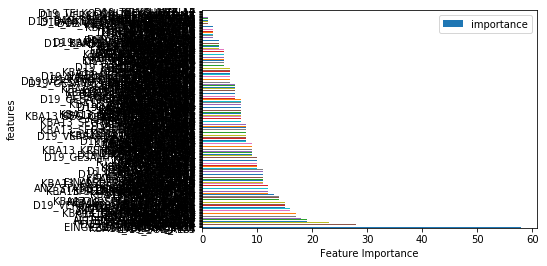

In [17]:
feature_df = plot_feature_importance(model, mailout_train_minmax.columns.values, n=N)

In [18]:
feature_list = feature_df['features'].values

In [19]:
selected_features, highest_score = feature_selection(feature_list, mailout_train_eng, target)

Feature: D19_SOZIALES, Score: 0.7212069196672453, Best Score: 0.7212069196672453
Feature: KBA13_ANZAHL_PKW, Score: 0.7150656596093442, Best Score: 0.7212069196672453
Feature: GEBURTSJAHR, Score: 0.7367291778885201, Best Score: 0.7367291778885201
Feature: CAMEO_DEU_2015, Score: 0.7350620809454622, Best Score: 0.7367291778885201
Feature: EINGEZOGENAM_HH_JAHR, Score: 0.731228719344937, Best Score: 0.7367291778885201
Feature: GFK_URLAUBERTYP, Score: 0.7427624442519514, Best Score: 0.7427624442519514
Feature: CJT_GESAMTTYP, Score: 0.7477718609463622, Best Score: 0.7477718609463622
Feature: VERDICHTUNGSRAUM, Score: 0.7480371947065364, Best Score: 0.7480371947065364
Feature: D19_KONSUMTYP_MAX, Score: 0.7509389961446764, Best Score: 0.7509389961446764
Feature: KBA05_DIESEL, Score: 0.7508408447109646, Best Score: 0.7509389961446764
Feature: KBA05_SEG2, Score: 0.7496399704547239, Best Score: 0.7509389961446764
Feature: KBA13_KW_90, Score: 0.7502326515946083, Best Score: 0.7509389961446764
Featur

Feature: KBA13_KW_121, Score: 0.7581671574324933, Best Score: 0.7677571911673537
Feature: KBA13_BJ_1999, Score: 0.7606092911107792, Best Score: 0.7677571911673537
Feature: KBA13_HALTER_65, Score: 0.7592462964402913, Best Score: 0.7677571911673537
Feature: KBA05_KW1, Score: 0.7609990895207487, Best Score: 0.7677571911673537
Feature: KBA13_CCM_3000, Score: 0.7599746912701091, Best Score: 0.7677571911673537
Feature: KBA13_KW_110, Score: 0.7526889860561773, Best Score: 0.7677571911673537
Feature: KBA05_SEG5, Score: 0.7548047791267021, Best Score: 0.7677571911673537
Feature: KBA05_SEG10, Score: 0.7602901267402244, Best Score: 0.7677571911673537
Feature: WEALTH, Score: 0.758040224165411, Best Score: 0.7677571911673537
Feature: KBA13_KMH_140, Score: 0.7583509322749808, Best Score: 0.7677571911673537
Feature: RT_UEBERGROESSE, Score: 0.7532951199135003, Best Score: 0.7677571911673537
Feature: KBA05_CCM2, Score: 0.7552158246846186, Best Score: 0.7677571911673537
Feature: KBA05_ALTER1, Score: 0.7

Feature: D19_VERSICHERUNGEN, Score: 0.7599727037007191, Best Score: 0.7679451655683744
Feature: D19_VERSAND_ANZ_12, Score: 0.7630422724112527, Best Score: 0.7679451655683744
Feature: D19_TELKO_DATUM, Score: 0.7592394734564004, Best Score: 0.7679451655683744
Feature: KBA05_SEG4, Score: 0.7538652998561678, Best Score: 0.7679451655683744
Feature: D19_TIERARTIKEL, Score: 0.7605965199644437, Best Score: 0.7679451655683744
Feature: KBA13_ALTERHALTER_60, Score: 0.7574324310564855, Best Score: 0.7679451655683744
Feature: KBA05_VORB2, Score: 0.757435493970527, Best Score: 0.7679451655683744
Feature: ANZ_HH_TITEL, Score: 0.7678185751648042, Best Score: 0.7679451655683744
Feature: D19_KINDERARTIKEL, Score: 0.7598466546059057, Best Score: 0.7679451655683744
Feature: KBA05_ZUL1, Score: 0.7628094608136721, Best Score: 0.7679451655683744
Feature: KBA05_KRSKLEIN, Score: 0.7597347938266115, Best Score: 0.7679451655683744
Feature: KBA05_VORB0, Score: 0.7573257682958309, Best Score: 0.7679451655683744
Fe

Feature: LP_FAMILIE_GROB, Score: 0.7598574766251243, Best Score: 0.7679451655683744
Feature: D19_VERSI_ANZ_12, Score: 0.7612977735108473, Best Score: 0.7679451655683744
Feature: MOBI_RASTER, Score: 0.7558558199501929, Best Score: 0.7679451655683744
Feature: KBA05_SEG3, Score: 0.7644669866698408, Best Score: 0.7679451655683744
Feature: D19_BANKEN_GROSS, Score: 0.7577323503942078, Best Score: 0.7679451655683744
Feature: KBA13_ALTERHALTER_61, Score: 0.7556395489196204, Best Score: 0.7679451655683744
Feature: D19_BANKEN_ONLINE_DATUM, Score: 0.7563604204927984, Best Score: 0.7679451655683744
Feature: D19_VERSI_OFFLINE_DATUM, Score: 0.7572471767059944, Best Score: 0.7679451655683744
Feature: D19_VERSAND_REST, Score: 0.7622088003047786, Best Score: 0.7679451655683744
Feature: D19_FREIZEIT, Score: 0.7647745258893744, Best Score: 0.7679451655683744
Feature: D19_GARTEN, Score: 0.7650586194785625, Best Score: 0.7679451655683744
Feature: D19_BANKEN_ANZ_12, Score: 0.7639027850200479, Best Score: 0.

In [20]:
selected_features

['D19_SOZIALES',
 'GEBURTSJAHR',
 'GFK_URLAUBERTYP',
 'CJT_GESAMTTYP',
 'VERDICHTUNGSRAUM',
 'D19_KONSUMTYP_MAX',
 'HH_EINKOMMEN_SCORE',
 'KBA05_ZUL4',
 'ALTERSKATEGORIE_FEIN',
 'KBA13_KW_120',
 'KBA13_VORB_0',
 'D19_VERSI_ONLINE_QUOTE_12',
 'D19_TELKO_ONLINE_QUOTE_12']

In [68]:
mailout_train.groupby(by="D19_SOZIALES").sum()[['RESPONSE']]

,RESPONSE
D19_SOZIALES,
0.0,28
1.0,374
2.0,8
3.0,23
4.0,12
5.0,2


In [69]:
mailout_train["D19_SOZIALES"].value_counts()

1.0    10991
0.0     9615
3.0     8624
4.0     3196
2.0     1491
5.0     1461
Name: D19_SOZIALES, dtype: int64

In [ ]:
def percent_customers(col, mailout_train):
    """
    """
    percent = df.isnull().sum()*100/len(df.index)
    new_df = pd.DataFrame({'percent': percent}, index=df.columns)
    return new_df
    

In [51]:
feature_importance_sorted = feature_importance.loc[feature_importance.importance > 15].sort_values(by=['importance'],ascending=False)
selected_features = feature_importance_sorted.feature.values
selected_n_features = selected_features
mailout_train_minmax = feature_scaling(mailout_train_eng, 'minmax')
mailout_train_minmax = mailout_train_minmax[mailout_train_minmax.columns[mailout_train_minmax.columns.isin(selected_features)]].astype('float')

In [52]:
mailout_train_minmax.shape

(42962, 33)

In [53]:
results = []
start = time.time()
cv_results = cross_val_score(model, mailout_train_minmax, target, cv=5, scoring='roc_auc', n_jobs=1)
stop = time.time()
results.append(np.round(cv_results.mean(), 4))
log = "Model: {}; Mean-AUC: {}; Std: {}; Training time: {} min".format('LGBM', 
                                                np.round(cv_results.mean(), 6), 
                                                np.round(cv_results.std(), 4),
                                                np.round((stop - start)/60, 2)
                                               )
print(log)

Model: LGBM; Mean-AUC: 0.739752; Std: 0.0147; Training time: 0.1 min


In [ ]:
columns_to_keep = ['D19_SOZIALES', 'GEBAEUDETYP', 'KBA05_GBZ', 'FINANZ_SPARER', 'VERS_TYP', 'KBA13_KRSSEG_VAN',
                  'D19_TIERARTIKEL', 'KBA13_KRSSEG_OBER']

LGBM
LGBM: 0.713093 (0.016574)
roc auc train score = 0.99
roc auc validation score = 0.71



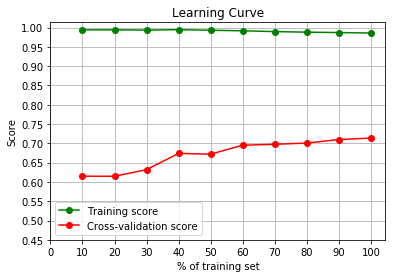

XGB


/opt/conda/lib/python3.6/site-packages/xgboost/data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")
/opt/conda/lib/python3.6/site-packages/xgboost/data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")
/opt/conda/lib/python3.6/site-packages/xgboost/data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")
/opt/conda/lib/python3.6/site-packages/xgboost/data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")
/opt/conda/lib/python3.6/site-packages/xgboost/data.py:115: UserWarning: Use subset (sliced data) of

XGB: 0.681090 (0.012542)


/opt/conda/lib/python3.6/site-packages/xgboost/data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")
/opt/conda/lib/python3.6/site-packages/xgboost/data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")
/opt/conda/lib/python3.6/site-packages/xgboost/data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")
/opt/conda/lib/python3.6/site-packages/xgboost/data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")
/opt/conda/lib/python3.6/site-packages/xgboost/data.py:115: UserWarning: Use subset (sliced data) of

/opt/conda/lib/python3.6/site-packages/xgboost/data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")
/opt/conda/lib/python3.6/site-packages/xgboost/data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")
/opt/conda/lib/python3.6/site-packages/xgboost/data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")
/opt/conda/lib/python3.6/site-packages/xgboost/data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")
/opt/conda/lib/python3.6/site-packages/xgboost/data.py:115: UserWarning: Use subset (sliced data) of

/opt/conda/lib/python3.6/site-packages/xgboost/data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")
/opt/conda/lib/python3.6/site-packages/xgboost/data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")
/opt/conda/lib/python3.6/site-packages/xgboost/data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")
/opt/conda/lib/python3.6/site-packages/xgboost/data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")
/opt/conda/lib/python3.6/site-packages/xgboost/data.py:115: UserWarning: Use subset (sliced data) of

roc auc train score = 0.99
roc auc validation score = 0.68



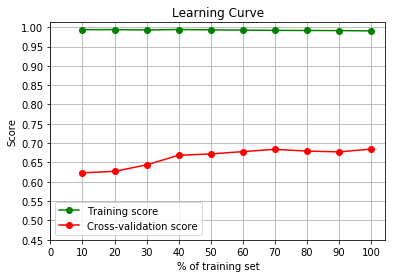

CPU times: user 1h 2min 25s, sys: 13.2 s, total: 1h 2min 38s
Wall time: 1h 3min 8s


In [10]:
%%time
models = create_baseline_models()
names, results = compare_models(mailout_train, target, models, curve=True)

RF
RF: 0.609228 (0.021233)
roc auc train score = 0.98
roc auc validation score = 0.61



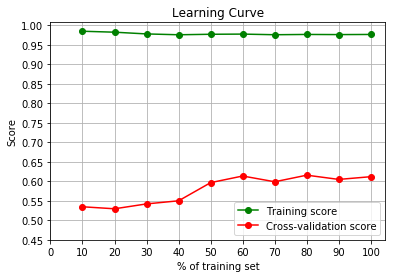

In [7]:
from sklearn.ensemble import RandomForestClassifier
SEED = 42
models = []
models.append(('RF', RandomForestClassifier(n_estimators=250, random_state=SEED)))
names, results = compare_models(mailout_train_eng, target, models, curve=True)

In [6]:
%%time
models = create_baseline_models() # unscaled
names, results = compare_models(mailout_train_eng, target, models)
baseline_score_df = pd.DataFrame({'Model':names, 'Score': results})
display(baseline_score_df)

Model: LGBM; Mean-AUC: 0.7059; Std: 0.0229; Training time: 1.14 min
Model: GB; Mean-AUC: 0.7526; Std: 0.0268; Training time: 4.73 min
Model: RF; Mean-AUC: 0.6092; Std: 0.0212; Training time: 2.85 min
Model: LogR; Mean-AUC: 0.6638; Std: 0.0196; Training time: 2.04 min
Model: MLP; Mean-AUC: 0.5828; Std: 0.0293; Training time: 2.58 min


/opt/conda/lib/python3.6/site-packages/xgboost/data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")
/opt/conda/lib/python3.6/site-packages/xgboost/data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")
/opt/conda/lib/python3.6/site-packages/xgboost/data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")
/opt/conda/lib/python3.6/site-packages/xgboost/data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


Model: XGB; Mean-AUC: 0.6689; Std: 0.0271; Training time: 5.03 min


/opt/conda/lib/python3.6/site-packages/xgboost/data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


,Model,Score
0,LGBM,0.7059
1,GB,0.7526
2,RF,0.6092
3,LogR,0.6638
4,MLP,0.5828
5,XGB,0.6689


CPU times: user 18min 16s, sys: 2.68 s, total: 18min 19s
Wall time: 18min 22s


In [6]:
baseline_score_df = pd.DataFrame({'Model':['LGBM', 'SVC','LogR','GB','RF','MLP','XGB'], 
                                  'Score': [0.7059, 0.5197,0.6638,0.7526,0.6092,0.5828,0.6689]})

In [7]:
%%time
#models = get_scaled_models('standard') # Standard Scaled
models = create_baseline_models() 
mailout_train_standard = feature_scaling(mailout_train_eng, 'standard')
names, results = compare_models(mailout_train_standard, target, models) # Using Standard Scaled Data
standard_scaler_score_df = pd.DataFrame({'Standard-Model':names, 'Score': results})
score_df = pd.concat([baseline_score_df, standard_scaler_score_df], axis=1)
display(score_df)

Model: LGBM; Mean-AUC: 0.6998; Std: 0.0265; Training time: 1.21 min
Model: GB; Mean-AUC: 0.7526; Std: 0.0268; Training time: 4.72 min
Model: RF; Mean-AUC: 0.6106; Std: 0.0199; Training time: 2.89 min
Model: LogR; Mean-AUC: 0.6594; Std: 0.0155; Training time: 1.33 min
Model: MLP; Mean-AUC: 0.6232; Std: 0.0216; Training time: 3.9 min


/opt/conda/lib/python3.6/site-packages/xgboost/data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")
/opt/conda/lib/python3.6/site-packages/xgboost/data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")
/opt/conda/lib/python3.6/site-packages/xgboost/data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")
/opt/conda/lib/python3.6/site-packages/xgboost/data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


Model: XGB; Mean-AUC: 0.6689; Std: 0.0271; Training time: 5.03 min


/opt/conda/lib/python3.6/site-packages/xgboost/data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


,Model,Score,Standard-Model,Score
0,LGBM,0.7059,LGBM,0.6998
1,GB,0.7526,GB,0.7526
2,RF,0.6092,RF,0.6106
3,LogR,0.6638,LogR,0.6594
4,MLP,0.5828,MLP,0.6232
5,XGB,0.6689,XGB,0.6689


CPU times: user 18min 58s, sys: 2.94 s, total: 19min 1s
Wall time: 19min 4s


In [8]:
%%time
models = create_baseline_models() 
mailout_train_minmax = feature_scaling(mailout_train_eng, 'minmax')
names, results = compare_models(mailout_train_minmax, target, models) # Using MinMax Scaled Data
min_max_score_df = pd.DataFrame({'MinMax-Model':names, 'Score': results})
score_df = pd.concat([baseline_score_df, standard_scaler_score_df, min_max_score_df], axis=1)
display(score_df)

Model: LGBM; Mean-AUC: 0.7058; Std: 0.0185; Training time: 0.75 min
Model: GB; Mean-AUC: 0.7526; Std: 0.0268; Training time: 4.68 min
Model: RF; Mean-AUC: 0.6115; Std: 0.0205; Training time: 2.75 min
Model: LogR; Mean-AUC: 0.6731; Std: 0.0176; Training time: 0.58 min
Model: MLP; Mean-AUC: 0.6007; Std: 0.0134; Training time: 9.07 min


/opt/conda/lib/python3.6/site-packages/xgboost/data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")
/opt/conda/lib/python3.6/site-packages/xgboost/data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")
/opt/conda/lib/python3.6/site-packages/xgboost/data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")
/opt/conda/lib/python3.6/site-packages/xgboost/data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


Model: XGB; Mean-AUC: 0.6689; Std: 0.0271; Training time: 4.97 min


/opt/conda/lib/python3.6/site-packages/xgboost/data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


,Model,Score,Standard-Model,Score,MinMax-Model,Score
0,LGBM,0.7059,LGBM,0.6998,LGBM,0.7058
1,GB,0.7526,GB,0.7526,GB,0.7526
2,RF,0.6092,RF,0.6106,RF,0.6115
3,LogR,0.6638,LogR,0.6594,LogR,0.6731
4,MLP,0.5828,MLP,0.6232,MLP,0.6007
5,XGB,0.6689,XGB,0.6689,XGB,0.6689


CPU times: user 22min 41s, sys: 2.61 s, total: 22min 44s
Wall time: 22min 48s


In [96]:
display(score_df)

,Model,Score,Model,Score,Model,Score
0,LGBM,0.70594,standardLGBM,0.700357,minmaxLGBM,0.705819


In [9]:
score_df

,Model,Score,Standard-Model,Score,MinMax-Model,Score
0,LGBM,0.7059,LGBM,0.6998,LGBM,0.7058
1,GB,0.7526,GB,0.7526,GB,0.7526
2,RF,0.6092,RF,0.6106,RF,0.6115
3,LogR,0.6638,LogR,0.6594,LogR,0.6731
4,MLP,0.5828,MLP,0.6232,MLP,0.6007
5,XGB,0.6689,XGB,0.6689,XGB,0.6689


### Hyperparameter Tuning of LGBM

In [6]:
mailout_train_eng = selected_features(mailout_train_eng)
mailout_train_minmax = feature_scaling(mailout_train_eng, 'minmax')

In [7]:
mailout_train_minmax.head()

,ALTERSKATEGORIE_FEIN,CJT_GESAMTTYP,D19_KONSUMTYP_MAX,D19_SOZIALES,D19_TELKO_ONLINE_QUOTE_12,D19_VERSI_ONLINE_QUOTE_12,GEBURTSJAHR,GFK_URLAUBERTYP,HH_EINKOMMEN_SCORE,KBA05_ZUL4,KBA13_KW_120,KBA13_VORB_0,VERDICHTUNGSRAUM
0,0.32,0.2,0.125,0.2,0.0,0.0,0.000000,0.636364,1.0,0.2,0.2,0.50,0.088889
1,0.52,0.2,0.375,1.0,0.0,0.0,0.970253,0.636364,0.0,0.2,0.6,0.50,0.000000
2,0.28,0.6,0.125,0.4,0.0,0.0,0.956371,0.181818,0.0,0.4,0.6,0.50,0.222222
3,0.24,0.2,0.125,0.2,0.0,0.0,0.953892,0.363636,0.6,0.8,0.6,0.75,0.111111
4,0.36,1.0,0.125,0.2,0.0,0.0,0.959841,0.272727,0.6,0.6,1.0,1.00,0.088889


In [26]:
ITERATIONS = 300
SEED = 42
bayes_cv_tuner_lgbm = BayesSearchCV(
    estimator = lgb.LGBMClassifier(
        application='binary',
        metric='auc',
        n_jobs=-1,
        verbose=-1,
    ),
    search_spaces = {
        'learning_rate': (0.001, 0.25, 'uniform'),
        'n_estimators': (10, 200),
        'max_depth': (2, 10),
        'num_leaves': (20, 100),
        'colsample_bytree':(0.9, 1.0, 'uniform'),
        'max_bin': (500, 1000),
        #'min_data_in_leaf':(20, 100),
        'min_child_samples': (1, 50),
        'reg_alpha': (1e-9, 10.0, 'log-uniform'),
        'reg_lambda': (1e-10, 1.0, 'log-uniform'),      
        'scale_pos_weight': (1,150, 'uniform'),

},    
    scoring = 'roc_auc',
    cv = StratifiedKFold(
        n_splits=5,
        shuffle=True,
        random_state=SEED
    ),
    n_jobs = -1,
    n_iter = ITERATIONS,  
    verbose = 0,
    refit = True,
    random_state = SEED
)

In [27]:
def print_param(x):
    """Status callback durring bayesian hyperparameter search"""

    iterations = pd.DataFrame(bayes_cv_tuner_lgbm.cv_results_)    
    
    best_params = pd.Series(bayes_cv_tuner_lgbm.best_params_)
    print('Iteration: {}\nBest ROC-AUC Score: {}\nBest parameters: {}\n'.format(
        len(iterations),
        np.round(bayes_cv_tuner_lgbm.best_score_, 6),
        bayes_cv_tuner_lgbm.best_params_
    ))

    algo_name = bayes_cv_tuner_lgbm.estimator.__class__.__name__
    iterations.to_csv(algo_name+"_bayes_cv_results.csv")

In [ ]:
%%time
result_lgbm = bayes_cv_tuner_lgbm.fit(mailout_train_minmax, target,callback=print_param)

Iteration: 1
Best ROC-AUC Score: 0.5968
Best parameters: OrderedDict([('colsample_bytree', 0.9410103958853314), ('learning_rate', 0.18220371005115393), ('max_bin', 966), ('max_depth', 5), ('min_child_samples', 34), ('n_estimators', 89), ('num_leaves', 48), ('reg_alpha', 0.024833752122391455), ('reg_lambda', 1.10823818604873e-07), ('scale_pos_weight', 98)])

Iteration: 2
Best ROC-AUC Score: 0.618472
Best parameters: OrderedDict([('colsample_bytree', 0.9837388355553285), ('learning_rate', 0.2209455040678347), ('max_bin', 652), ('max_depth', 10), ('min_child_samples', 43), ('n_estimators', 22), ('num_leaves', 31), ('reg_alpha', 3.43458268604567e-06), ('reg_lambda', 0.00022766224742996492), ('scale_pos_weight', 143)])

Iteration: 3
Best ROC-AUC Score: 0.618472
Best parameters: OrderedDict([('colsample_bytree', 0.9837388355553285), ('learning_rate', 0.2209455040678347), ('max_bin', 652), ('max_depth', 10), ('min_child_samples', 43), ('n_estimators', 22), ('num_leaves', 31), ('reg_alpha', 3.

Iteration: 25
Best ROC-AUC Score: 0.767186
Best parameters: OrderedDict([('colsample_bytree', 0.9), ('learning_rate', 0.001), ('max_bin', 801), ('max_depth', 7), ('min_child_samples', 50), ('n_estimators', 166), ('num_leaves', 20), ('reg_alpha', 1e-09), ('reg_lambda', 1e-10), ('scale_pos_weight', 117)])

Iteration: 26
Best ROC-AUC Score: 0.770097
Best parameters: OrderedDict([('colsample_bytree', 0.9247589237764383), ('learning_rate', 0.08032636967319591), ('max_bin', 500), ('max_depth', 2), ('min_child_samples', 20), ('n_estimators', 142), ('num_leaves', 47), ('reg_alpha', 1.474768826278317e-07), ('reg_lambda', 5.5934235783061845e-09), ('scale_pos_weight', 29)])

Iteration: 27
Best ROC-AUC Score: 0.770097
Best parameters: OrderedDict([('colsample_bytree', 0.9247589237764383), ('learning_rate', 0.08032636967319591), ('max_bin', 500), ('max_depth', 2), ('min_child_samples', 20), ('n_estimators', 142), ('num_leaves', 47), ('reg_alpha', 1.474768826278317e-07), ('reg_lambda', 5.59342357830

Iteration: 48
Best ROC-AUC Score: 0.770932
Best parameters: OrderedDict([('colsample_bytree', 0.9), ('learning_rate', 0.05766598726984406), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 32), ('n_estimators', 200), ('num_leaves', 88), ('reg_alpha', 10.0), ('reg_lambda', 8.953220169420035e-05), ('scale_pos_weight', 23)])

Iteration: 49
Best ROC-AUC Score: 0.770932
Best parameters: OrderedDict([('colsample_bytree', 0.9), ('learning_rate', 0.05766598726984406), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 32), ('n_estimators', 200), ('num_leaves', 88), ('reg_alpha', 10.0), ('reg_lambda', 8.953220169420035e-05), ('scale_pos_weight', 23)])

Iteration: 50
Best ROC-AUC Score: 0.770932
Best parameters: OrderedDict([('colsample_bytree', 0.9), ('learning_rate', 0.05766598726984406), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 32), ('n_estimators', 200), ('num_leaves', 88), ('reg_alpha', 10.0), ('reg_lambda', 8.953220169420035e-05), ('scale_pos_weight', 23

Iteration: 73
Best ROC-AUC Score: 0.770932
Best parameters: OrderedDict([('colsample_bytree', 0.9), ('learning_rate', 0.05766598726984406), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 32), ('n_estimators', 200), ('num_leaves', 88), ('reg_alpha', 10.0), ('reg_lambda', 8.953220169420035e-05), ('scale_pos_weight', 23)])

Iteration: 74
Best ROC-AUC Score: 0.770932
Best parameters: OrderedDict([('colsample_bytree', 0.9), ('learning_rate', 0.05766598726984406), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 32), ('n_estimators', 200), ('num_leaves', 88), ('reg_alpha', 10.0), ('reg_lambda', 8.953220169420035e-05), ('scale_pos_weight', 23)])

Iteration: 75
Best ROC-AUC Score: 0.770932
Best parameters: OrderedDict([('colsample_bytree', 0.9), ('learning_rate', 0.05766598726984406), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 32), ('n_estimators', 200), ('num_leaves', 88), ('reg_alpha', 10.0), ('reg_lambda', 8.953220169420035e-05), ('scale_pos_weight', 23

Iteration: 98
Best ROC-AUC Score: 0.770932
Best parameters: OrderedDict([('colsample_bytree', 0.9), ('learning_rate', 0.05766598726984406), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 32), ('n_estimators', 200), ('num_leaves', 88), ('reg_alpha', 10.0), ('reg_lambda', 8.953220169420035e-05), ('scale_pos_weight', 23)])

Iteration: 99
Best ROC-AUC Score: 0.770932
Best parameters: OrderedDict([('colsample_bytree', 0.9), ('learning_rate', 0.05766598726984406), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 32), ('n_estimators', 200), ('num_leaves', 88), ('reg_alpha', 10.0), ('reg_lambda', 8.953220169420035e-05), ('scale_pos_weight', 23)])

Iteration: 100
Best ROC-AUC Score: 0.770932
Best parameters: OrderedDict([('colsample_bytree', 0.9), ('learning_rate', 0.05766598726984406), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 32), ('n_estimators', 200), ('num_leaves', 88), ('reg_alpha', 10.0), ('reg_lambda', 8.953220169420035e-05), ('scale_pos_weight', 2

Iteration: 125
Best ROC-AUC Score: 0.770957
Best parameters: OrderedDict([('colsample_bytree', 0.9), ('learning_rate', 0.001), ('max_bin', 879), ('max_depth', 8), ('min_child_samples', 40), ('n_estimators', 200), ('num_leaves', 20), ('reg_alpha', 1e-09), ('reg_lambda', 1e-10), ('scale_pos_weight', 41)])

Iteration: 126
Best ROC-AUC Score: 0.770957
Best parameters: OrderedDict([('colsample_bytree', 0.9), ('learning_rate', 0.001), ('max_bin', 879), ('max_depth', 8), ('min_child_samples', 40), ('n_estimators', 200), ('num_leaves', 20), ('reg_alpha', 1e-09), ('reg_lambda', 1e-10), ('scale_pos_weight', 41)])

Iteration: 127
Best ROC-AUC Score: 0.770957
Best parameters: OrderedDict([('colsample_bytree', 0.9), ('learning_rate', 0.001), ('max_bin', 879), ('max_depth', 8), ('min_child_samples', 40), ('n_estimators', 200), ('num_leaves', 20), ('reg_alpha', 1e-09), ('reg_lambda', 1e-10), ('scale_pos_weight', 41)])

Iteration: 128
Best ROC-AUC Score: 0.770957
Best parameters: OrderedDict([('colsam

Iteration: 152
Best ROC-AUC Score: 0.770957
Best parameters: OrderedDict([('colsample_bytree', 0.9), ('learning_rate', 0.001), ('max_bin', 879), ('max_depth', 8), ('min_child_samples', 40), ('n_estimators', 200), ('num_leaves', 20), ('reg_alpha', 1e-09), ('reg_lambda', 1e-10), ('scale_pos_weight', 41)])

Iteration: 153
Best ROC-AUC Score: 0.770957
Best parameters: OrderedDict([('colsample_bytree', 0.9), ('learning_rate', 0.001), ('max_bin', 879), ('max_depth', 8), ('min_child_samples', 40), ('n_estimators', 200), ('num_leaves', 20), ('reg_alpha', 1e-09), ('reg_lambda', 1e-10), ('scale_pos_weight', 41)])

Iteration: 154
Best ROC-AUC Score: 0.770957
Best parameters: OrderedDict([('colsample_bytree', 0.9), ('learning_rate', 0.001), ('max_bin', 879), ('max_depth', 8), ('min_child_samples', 40), ('n_estimators', 200), ('num_leaves', 20), ('reg_alpha', 1e-09), ('reg_lambda', 1e-10), ('scale_pos_weight', 41)])

Iteration: 155
Best ROC-AUC Score: 0.770957
Best parameters: OrderedDict([('colsam

Iteration: 179
Best ROC-AUC Score: 0.771576
Best parameters: OrderedDict([('colsample_bytree', 0.9), ('learning_rate', 0.05923987211121765), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 1), ('n_estimators', 90), ('num_leaves', 100), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 1)])

Iteration: 180
Best ROC-AUC Score: 0.771576
Best parameters: OrderedDict([('colsample_bytree', 0.9), ('learning_rate', 0.05923987211121765), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 1), ('n_estimators', 90), ('num_leaves', 100), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 1)])

Iteration: 181
Best ROC-AUC Score: 0.771576
Best parameters: OrderedDict([('colsample_bytree', 0.9), ('learning_rate', 0.05923987211121765), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 1), ('n_estimators', 90), ('num_leaves', 100), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 1)])

Iteration: 182
Best ROC-AUC Score: 0.771576
Best 

Iteration: 205
Best ROC-AUC Score: 0.771963
Best parameters: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.08012601480513992), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 12), ('n_estimators', 118), ('num_leaves', 20), ('reg_alpha', 10.0), ('reg_lambda', 1.4453507295049998e-10), ('scale_pos_weight', 26)])

Iteration: 206
Best ROC-AUC Score: 0.771963
Best parameters: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.08012601480513992), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 12), ('n_estimators', 118), ('num_leaves', 20), ('reg_alpha', 10.0), ('reg_lambda', 1.4453507295049998e-10), ('scale_pos_weight', 26)])

Iteration: 207
Best ROC-AUC Score: 0.771963
Best parameters: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.08012601480513992), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 12), ('n_estimators', 118), ('num_leaves', 20), ('reg_alpha', 10.0), ('reg_lambda', 1.4453507295049998e-10), ('scale_pos_weigh

Iteration: 230
Best ROC-AUC Score: 0.773114
Best parameters: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.23499721391609643), ('max_bin', 767), ('max_depth', 2), ('min_child_samples', 50), ('n_estimators', 52), ('num_leaves', 81), ('reg_alpha', 10.0), ('reg_lambda', 0.005622544419547855), ('scale_pos_weight', 15)])

Iteration: 231
Best ROC-AUC Score: 0.773114
Best parameters: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.23499721391609643), ('max_bin', 767), ('max_depth', 2), ('min_child_samples', 50), ('n_estimators', 52), ('num_leaves', 81), ('reg_alpha', 10.0), ('reg_lambda', 0.005622544419547855), ('scale_pos_weight', 15)])

Iteration: 232
Best ROC-AUC Score: 0.773114
Best parameters: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.23499721391609643), ('max_bin', 767), ('max_depth', 2), ('min_child_samples', 50), ('n_estimators', 52), ('num_leaves', 81), ('reg_alpha', 10.0), ('reg_lambda', 0.005622544419547855), ('scale_pos_weight', 15)])



Best params: 0.76 OrderedDict([('colsample_bytree', 0.9238574532834115), ('learning_rate', 0.01), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 1), ('n_estimators', 40), ('num_leaves', 89), ('reg_alpha', 10.0), ('reg_lambda', 0.02596034024971144), ('scale_pos_weight', 80)])


Model #50
Best ROC-AUC: 0.7644
Best params: OrderedDict([('colsample_bytree', 0.946913879853184), ('learning_rate', 0.04799599894049769), ('max_bin', 1000), ('max_depth', 2), ('min_child_samples', 1), ('n_estimators', 28), ('num_leaves', 100), ('reg_alpha', 5.432508975487921e-09), ('reg_lambda', 5.280547754951558e-07), ('scale_pos_weight', 22)])

Model #102
Best ROC-AUC: 0.7644
Best params: OrderedDict([('colsample_bytree', 0.9), ('learning_rate', 0.06184798151304283), ('max_bin', 752), ('max_depth', 2), ('min_child_samples', 1), ('n_estimators', 74), ('num_leaves', 100), ('reg_alpha', 1e-09), ('reg_lambda', 1e-10), ('scale_pos_weight', 34)])

Iteration: 101
Best ROC-AUC Score: 0.773247
Best parameters: OrderedDict([('colsample_bytree', 0.99), ('learning_rate', 0.050442486048289055), ('max_bin', 1190), ('max_depth', 2), ('min_child_samples', 0), ('n_estimators', 264), ('num_leaves', 20), ('reg_alpha', 0.0001344342904327156), ('reg_lambda', 1.0), ('scale_pos_weight', 1)])

Iteration: 221
Best ROC-AUC Score: 0.77389
Best parameters: OrderedDict([('colsample_bytree', 0.9915167933858116), ('learning_rate', 0.04459589320867403), ('max_bin', 643), ('max_depth', 2), ('min_child_samples', 50), ('n_estimators', 268), ('num_leaves', 20), ('reg_alpha', 1e-09), ('reg_lambda', 1.0), ('scale_pos_weight', 1)])

Iteration: 232
Best ROC-AUC Score: 0.773114
Best parameters: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.23499721391609643), ('max_bin', 767), ('max_depth', 2), ('min_child_samples', 50), ('n_estimators', 52), ('num_leaves', 81), ('reg_alpha', 10.0), ('reg_lambda', 0.005622544419547855), ('scale_pos_weight', 15)])

In [ ]:
bayes_lgbm = bayes_cv_tuner_lgbm.best_estimator_
bayes_lgbm

In [9]:
#232
bayes_lgbm = lgb.LGBMClassifier(application='binary', colsample_bytree=1.0, learning_rate=0.23499721391609643,
               max_bin=767, max_depth=2, metric='auc', min_child_samples=50,
               n_estimators=52, num_leaves=81, reg_alpha=10.0,
               reg_lambda=0.005622544419547855, scale_pos_weight=15, verbose=-1)

In [10]:
bayes_lgbm.fit(mailout_train_minmax, target)

LGBMClassifier(application='binary', learning_rate=0.23499721391609643,
               max_bin=767, max_depth=2, metric='auc', min_child_samples=50,
               n_estimators=52, num_leaves=81, reg_alpha=10.0,
               reg_lambda=0.005622544419547855, scale_pos_weight=15,
               verbose=-1)

In [11]:
joblib.dump(bayes_lgbm, 'lgbm_232.pkl')

['lgbm_232.pkl']

In [12]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [13]:
# Loading feature values mapping files
dias = pd.read_excel("DIAS Attributes - Values 2017.xlsx", header=1)
dias['Attribute'] = dias['Attribute'].ffill()

In [14]:
lnr = pd.DataFrame(mailout_test['LNR'].astype('int32'))

In [15]:
mailout_test.drop(['LNR'], inplace=True, axis=1)
mailout_test_eng = preprocess(mailout_test, dias)

Dropping columns with high percentage of missing values ['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ']
label encoding CAMEO_DEU_2015
Convert CAMEO_DEUG_2015 str to float
Mapping OST_WEST_KZ categorical
Splitting CAMEO_INTL_2015 Feature into 2 features FAMILY and WEALTH
Splitting LP_LEBENSPHASE_FEIN into two features INCOME and AGE
Splitting PRAEGENDE_JUGENDJAHRE into two DECADE and MOVEMENT
Get the registeration year from EINGEFUEGT_AM
Dropping unwanted columns ['D19_LETZTER_KAUF_BRANCHE', 'CAMEO_INTL_2015', 'LP_LEBENSPHASE_FEIN', 'PRAEGENDE_JUGENDJAHRE', 'EINGEFUEGT_AM']
Imputing missing values with most frequent value


In [16]:
selected_features = ['D19_SOZIALES',
 'GEBURTSJAHR',
 'GFK_URLAUBERTYP',
 'CJT_GESAMTTYP',
 'VERDICHTUNGSRAUM',
 'D19_KONSUMTYP_MAX',
 'HH_EINKOMMEN_SCORE',
 'KBA05_ZUL4',
 'ALTERSKATEGORIE_FEIN',
 'KBA13_KW_120',
 'KBA13_VORB_0',
 'D19_VERSI_ONLINE_QUOTE_12',
 'D19_TELKO_ONLINE_QUOTE_12']
mailout_train_eng = mailout_train_eng[mailout_train_eng.columns[mailout_train_eng.columns.isin(selected_features)]].astype('float')
mailout_test_eng = mailout_test_eng[mailout_test_eng.columns[mailout_test_eng.columns.isin(selected_features)]].astype('float')

In [17]:
mailout_test_eng.head()

,ALTERSKATEGORIE_FEIN,CJT_GESAMTTYP,D19_KONSUMTYP_MAX,D19_SOZIALES,D19_TELKO_ONLINE_QUOTE_12,D19_VERSI_ONLINE_QUOTE_12,GEBURTSJAHR,GFK_URLAUBERTYP,HH_EINKOMMEN_SCORE,KBA05_ZUL4,KBA13_KW_120,KBA13_VORB_0,VERDICHTUNGSRAUM
0,6.0,5.0,2.0,1.0,0.0,0.0,0.0,10.0,4.0,2.0,4.0,3.0,23.0
1,0.0,1.0,2.0,1.0,0.0,0.0,0.0,10.0,5.0,0.0,3.0,2.0,0.0
2,11.0,2.0,8.0,0.0,0.0,0.0,1946.0,5.0,5.0,5.0,0.0,5.0,15.0
3,0.0,4.0,8.0,0.0,0.0,0.0,0.0,6.0,3.0,3.0,3.0,3.0,10.0
4,13.0,6.0,1.0,0.0,0.0,0.0,1956.0,10.0,4.0,1.0,1.0,1.0,0.0


In [18]:
# Applying the same scaler from trained data to test
scaler = MinMaxScaler().fit(mailout_train_eng)
mailout_test_minmax = scaler.transform(mailout_test_eng)

In [19]:
# load model
lgbm_model = joblib.load('lgbm_232.pkl')
predictions = lgbm_model.predict_proba(mailout_test_minmax)[:,1]

In [20]:
response_df = pd.DataFrame(predictions, columns =['RESPONSE'])
submission_df = pd.concat([lnr, response_df], axis=1)
submission_df.set_index('LNR', inplace = True)

In [21]:
submission_df.shape

(42833, 1)

In [22]:
submission_df.to_csv("Avrato_kaggle_submission_lgbm_232_5.csv")

### Hyperparameter Tuning of GB

In [15]:
ITERATIONS = 50
SEED = 42
bayes_cv_tuner_gb = BayesSearchCV(
    estimator = GradientBoostingClassifier(
        #application='binary',
        #criterion='auc',
        #n_jobs=-1,
        #verbose=-1,
    ),
    search_spaces = {
        'learning_rate': (0.001, 0.25, 'uniform'),
        'n_estimators': (50, 2000),
        'max_depth': (2, 10),
        'min_samples_split':(2, 100),
        'min_samples_leaf': (1, 10),
        'max_features': (10, 30),
        'subsample':(0.7, 1.0),
},    
    scoring = 'roc_auc',
    cv = StratifiedKFold(
        n_splits=5,
        shuffle=True,
        random_state=SEED
    ),
    n_jobs = -1,
    n_iter = ITERATIONS,  
    #verbose = 0,
    refit = True,
    random_state = SEED
)

def print_param(x):
    """Status callback durring bayesian hyperparameter search"""
    
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(bayes_cv_tuner_gb.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(bayes_cv_tuner_gb.best_params_)
    print('Model #{}\nBest ROC-AUC: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bayes_cv_tuner_gb.best_score_, 4),
        bayes_cv_tuner_gb.best_params_
    ))
    
    # Save all model results
    clf_name = bayes_cv_tuner_gb.estimator.__class__.__name__
    all_models.to_csv(clf_name+"_cv_results.csv")

In [ ]:
%%time
result_gb = bayes_cv_tuner_gb.fit(mailout_train_minmax, target,callback=print_param)

Model #1
Best ROC-AUC: 0.6413
Best params: OrderedDict([('learning_rate', 0.10311588575447515), ('max_depth', 8), ('max_features', 29), ('min_samples_leaf', 4), ('min_samples_split', 68), ('n_estimators', 858), ('subsample', 0.8052794004697432)])

Model #2
Best ROC-AUC: 0.6469
Best params: OrderedDict([('learning_rate', 0.20950970053276782), ('max_depth', 9), ('max_features', 16), ('min_samples_leaf', 10), ('min_samples_split', 87), ('n_estimators', 172), ('subsample', 0.7414925614835726)])

Model #3
Best ROC-AUC: 0.6469
Best params: OrderedDict([('learning_rate', 0.20950970053276782), ('max_depth', 9), ('max_features', 16), ('min_samples_leaf', 10), ('min_samples_split', 87), ('n_estimators', 172), ('subsample', 0.7414925614835726)])

Model #4
Best ROC-AUC: 0.709
Best params: OrderedDict([('learning_rate', 0.20328660110098348), ('max_depth', 3), ('max_features', 22), ('min_samples_leaf', 8), ('min_samples_split', 53), ('n_estimators', 236), ('subsample', 0.9267401598507645)])

Model #

Model #36
Best ROC-AUC: 0.7521
Best params: OrderedDict([('learning_rate', 0.001), ('max_depth', 6), ('max_features', 30), ('min_samples_leaf', 10), ('min_samples_split', 2), ('n_estimators', 2000), ('subsample', 0.7195263583720765)])

Model #37
Best ROC-AUC: 0.7521
Best params: OrderedDict([('learning_rate', 0.001), ('max_depth', 6), ('max_features', 30), ('min_samples_leaf', 10), ('min_samples_split', 2), ('n_estimators', 2000), ('subsample', 0.7195263583720765)])

Model #38
Best ROC-AUC: 0.7521
Best params: OrderedDict([('learning_rate', 0.001), ('max_depth', 6), ('max_features', 30), ('min_samples_leaf', 10), ('min_samples_split', 2), ('n_estimators', 2000), ('subsample', 0.7195263583720765)])

Model #39
Best ROC-AUC: 0.7521
Best params: OrderedDict([('learning_rate', 0.001), ('max_depth', 6), ('max_features', 30), ('min_samples_leaf', 10), ('min_samples_split', 2), ('n_estimators', 2000), ('subsample', 0.7195263583720765)])



In [ ]:
bayes_gb = bayes_cv_tuner_gb.best_estimator_
bayes_gb

In [ ]:
bayes_gb.fit(mailout_train_minmax, target)

In [ ]:
joblib.dump(bayes_lgbm, 'gb_50.pkl')